## 1. Instalaciones necesarias

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 18.2 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
#import pydicom
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import shutil


In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocesamiento conjunto RSNA

## 2. Leer los datos

In [ ]:
main_dir = '/content/drive/MyDrive/0tfm/RSNA/'

lables = 'stage_2_train_labels.csv'
lables_full = 'stage_2_detailed_class_info.csv'
images="stage_2_train_images/"


lables_dir = main_dir + lables
lables_full_dir = main_dir + lables_full
images_dir = main_dir + images
images_dir_png = main_dir + 'converted_to_png_images'
mask_dir_png = main_dir + 'converted_to_png_mask'
dataset_agrupado_dir =main_dir + "df_coordinates_listed.csv"

images_dir_png_balanc = main_dir + 'balanced_png_images'
mask_dir_png_balanc =  main_dir + 'balanced_png_mask'

In [ ]:
print(len(os.listdir(images_dir_png)))
print(len(os.listdir(mask_dir_png)))

26570
26570


In [ ]:
df = pd.read_csv(main_dir + 'df_extended.csv').drop("class", axis=1)
df['filename']=df["patientId"] + ".png"
df['filename_masc']=df["patientId"] + "_mascara.png"
df.head()

,patientId,x,y,width,height,Target,PatientAge,PatientSex,ViewPosition,filename,filename_masc
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,51.0,F,PA,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,0004cfab-14fd-4e49-80ba-63a80b6bddd6_mascara.png
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,48.0,F,PA,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png,00313ee0-9eaa-42f4-b0ab-c148ed3241cd_mascara.png
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,19.0,M,AP,00322d4d-1c29-4943-afc9-b6754be640eb.png,00322d4d-1c29-4943-afc9-b6754be640eb_mascara.png
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,28.0,M,PA,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,003d8fa0-6bf1-40ed-b54c-ac657f8495c5_mascara.png
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,32.0,F,AP,00436515-870c-4b36-a041-de91049b9ab4.png,00436515-870c-4b36-a041-de91049b9ab4_mascara.png


# 4.3.3.1. Preprocesamiento de datos numéricos

## Imputar los nulos

Reemplazar los valores nulos en coordinadas con 0

Reemplazar los valores nulos en PatientAge con la mediana.

Reemplazar los valores nulos en PatientSex y ViewPosition con la moda.

In [ ]:
df_modif=df.copy()
df_modif[['x', 'y', 'width', 'height']] = df_modif[['x', 'y', 'width', 'height']].fillna(0)
df_modif["PatientAge"].fillna(df_modif["PatientAge"].median(), inplace=True)
df_modif["PatientSex"].fillna(df_modif["PatientSex"].mode()[0],inplace=True)
df_modif["ViewPosition"].fillna(df_modif["ViewPosition"].mode()[0],inplace=True)

valores nulos por columnas despues de imputacion:

In [ ]:
df_modif.isna().sum()

,0
patientId,0
x,0
y,0
width,0
height,0
Target,0
PatientAge,0
PatientSex,0
ViewPosition,0
filename,0


##  Codificar valores categóricos

In [ ]:
label_encoder_sex = LabelEncoder()
df_modif['PatientSex_enc'] = label_encoder_sex.fit_transform(df_modif['PatientSex'])

label_encoder_view = LabelEncoder()
df_modif['ViewPosition_enc'] = label_encoder_view.fit_transform(df_modif['ViewPosition'])

df_modif.head()

,patientId,x,y,width,height,Target,PatientAge,PatientSex,ViewPosition,filename,filename_masc,PatientSex_enc,ViewPosition_enc
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,51.0,F,PA,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,0004cfab-14fd-4e49-80ba-63a80b6bddd6_mascara.png,0,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,48.0,F,PA,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png,00313ee0-9eaa-42f4-b0ab-c148ed3241cd_mascara.png,0,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,19.0,M,AP,00322d4d-1c29-4943-afc9-b6754be640eb.png,00322d4d-1c29-4943-afc9-b6754be640eb_mascara.png,1,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,28.0,M,PA,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,003d8fa0-6bf1-40ed-b54c-ac657f8495c5_mascara.png,1,1
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,32.0,F,AP,00436515-870c-4b36-a041-de91049b9ab4.png,00436515-870c-4b36-a041-de91049b9ab4_mascara.png,0,0


## Agrupar coordinadas

In [ ]:
# Agrupar coordenadas por imagen porque tenemos múltiples filas en caso de varias áreas de opacidad

grouped_df = df_modif.groupby(['filename',"filename_masc","Target","PatientAge","PatientSex_enc","ViewPosition_enc"]).apply(lambda group: group[['x', 'y', 'width', 'height']].to_dict(orient='records')).reset_index()
grouped_df.columns = ['filename',"filename_masc","Target","PatientAge","PatientSex","ViewPosition", 'lista_coordinadas']  # Renombrar columnas
print("dimensiones de la tabla agrupada", grouped_df.shape)
grouped_df.head(3)


dimensiones de la tabla agrupada (26684, 7)


,filename,filename_masc,Target,PatientAge,PatientSex,ViewPosition,lista_coordinadas
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,0004cfab-14fd-4e49-80ba-63a80b6bddd6_mascara.png,0,51.0,0,1,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."
1,000924cf-0f8d-42bd-9158-1af53881a557.png,000924cf-0f8d-42bd-9158-1af53881a557_mascara.png,0,19.0,0,0,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."
2,000db696-cf54-4385-b10b-6b16fbb3f985.png,000db696-cf54-4385-b10b-6b16fbb3f985_mascara.png,1,25.0,0,0,"[{'x': 316.0, 'y': 318.0, 'width': 170.0, 'hei..."


In [ ]:
grouped_df.to_csv("df_coordinates_listed.csv",index=False)
print("fichero guardado")

fichero guardado


## Normalizar los datos numéricos

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
grouped_df['PatientAge'] = grouped_df.fit_transform(grouped_df['PatientAge'])

# 4.3.3.2. Preprocesamiento de imágenes

## Convertir Dicom a PNG

Comprobar bits por pixel para evaluar si habrá perdida de informacion al convertir imagenes, porque a veses imagenes de Dicom pueden haber mayor rango de valores

In [ ]:
dicom_path = images_dir + '/' + 'c1f7889a-9ea9-4acb-b64c-b737c929599a.dcm'
dicom_image = pydicom.dcmread(dicom_path)
bits_allocated = dicom_image.BitsAllocated
print(f"Bits per pixel: {bits_allocated}")

Bits per pixel: 8


In [ ]:
# Función para convertir imágenes DICOM a PNG
def convert_dicom_to_png(dicom_path, output_path):
    dicom_image = pydicom.dcmread(dicom_path)
    image_array = dicom_image.pixel_array
    # Normaliza el rango de píxeles y convierte a uint8
    image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array)) * 255
    image_array = image_array.astype(np.uint8)
    image = Image.fromarray(image_array)
    image.save(output_path)

In [ ]:
# Convierte todos los DICOM a PNG
for filename in os.listdir(images_dir):
    if filename.endswith('.dcm'):
        dicom_path = os.path.join(images_dir, filename)
        png_path = os.path.join(images_dir_png, filename.replace('.dcm', '.png'))
        convert_dicom_to_png(dicom_path, png_path)


 las imágenes DICOM  ya tienen un rango de valores de 0 a 255. Esto es común en algunas modalidades DICOM que almacenan imágenes en un formato ya normalizado a 8 bits por píxel. Dado que tanto las imágenes DICOM como las PNG tienen el mismo rango de valores (0-255), la conversión entre los dos formatos no debería causar pérdida de información significativa.

Comprobar si los datos guardados en png son identicas en tamaño y en array numerico a png

Las imágenes son idénticas: True
DICOM Image - Min value: 0, Max value: 255
PNG Image - Min value: 0, Max value: 255


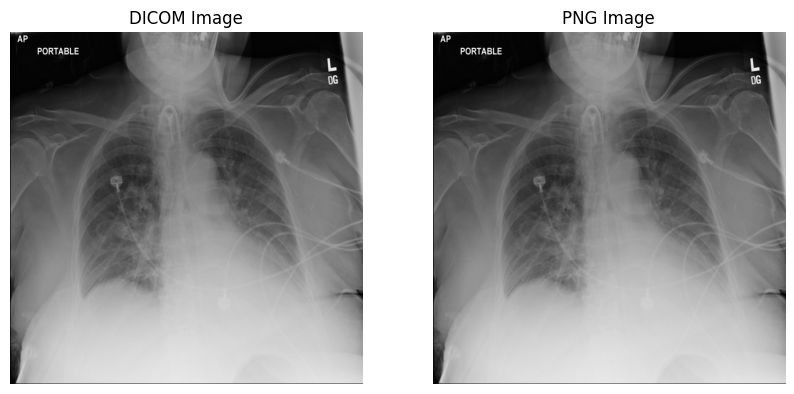

In [ ]:
# Rutas a los archivos DICOM y PNG
dicom_path = images_dir + '/' + 'c1f7889a-9ea9-4acb-b64c-b737c929599a.dcm'
png_path = images_dir_png + '/' + 'c1f7889a-9ea9-4acb-b64c-b737c929599a.png'

# Función para cargar y visualizar DICOM
def load_dicom_image(dicom_path):
    dicom_image = pydicom.dcmread(dicom_path)
    image_array = dicom_image.pixel_array
    return image_array

# Función para cargar y visualizar PNG
def load_png_image(png_path):
    image = Image.open(png_path).convert('L')  # Convertir a escala de grises si es necesario
    image_array = np.array(image)
    return image_array

# Función para comprobar el rango de valores
def check_range(image_array, label):
    print(f"{label} - Min value: {np.min(image_array)}, Max value: {np.max(image_array)}")


# Cargar imágenes
dicom_image = load_dicom_image(dicom_path)
png_image = load_png_image(png_path)

# Comprobar si las dimensiones son iguales
if dicom_image.shape == png_image.shape:
    # Comprobar si los datos son idénticos
    are_identical = np.array_equal(dicom_image, png_image)
    print("Las imágenes son idénticas:", are_identical)
else:
    print("Las imágenes tienen dimensiones diferentes.")

# Comprobar el rango de valores
check_range(dicom_image, 'DICOM Image')
check_range(png_image, 'PNG Image')

# Visualizar imágenes juntas
plt.figure(figsize=(10, 5))

# Mostrar imagen DICOM
plt.subplot(1, 2, 1)
plt.imshow(dicom_image, cmap='gray')
plt.title('DICOM Image')
plt.axis('off')

# Mostrar imagen PNG
plt.subplot(1, 2, 2)
plt.imshow(png_image, cmap='gray')
plt.title('PNG Image')
plt.axis('off')

plt.show()

Comprobar que mi funcion que usaré al cargar los datos devuelve info identica a dicom, sin normalisar la imagen es identica

In [ ]:
# Rutas a los archivos DICOM y PNG
dicom_path = images_dir + '/' + 'c1f7889a-9ea9-4acb-b64c-b737c929599a.dcm'
png_path = images_dir_png + '/' + 'c1f7889a-9ea9-4acb-b64c-b737c929599a.png'

# Función para cargar una imagen DICOM
def load_dicom_image(dicom_path):
    dicom_image = pydicom.dcmread(dicom_path)
    image_array = dicom_image.pixel_array
    # Convertir a 3 canales
    if image_array.ndim == 2:  # Si es en escala de grises
        image_array = np.stack((image_array,)*3, axis=-1)  # Repetir el canal 3 veces
    return image_array


# Función para cargar imágenes que usaré para leer imagenes en dataset
def load_image(image_path, new_size=(1024,  1024), augmentation=0):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

      # Redimensionar la imagen
    image = tf.image.resize(image, new_size)

        # Normalizar la imagen
    #image = tf.cast(image, tf.float32) / 255.0  # Escalar a [0, 1]

    return image

dicom_image = load_dicom_image(dicom_path)
png_image = load_image(png_path)

# # Comprobar si los datos son idéntico
print("Las imágenes son idénticas:", np.array_equal(dicom_image, png_image.numpy()))


Las imágenes son idénticas: True


In [ ]:
png_image[0].shape

TensorShape([1024, 3])

## Crear máscaras a partir de múltiples áreas y sus coordinadas

In [ ]:
# Función para crear una máscara a partir de las coordenadas y imagenes de torax png
def crear_mascara (image_path, lista_coordinadas):
    width, height = (1024, 1024)

    # Inicializar la máscara con ceros (negro)
    mascara = np.zeros((height, width), dtype=np.uint8)

    for coord in lista_coordinadas:
        # Extrae las coordenadas
        x, y, w, h = int(coord['x']), int(coord['y']), int(coord['width']), int(coord['height'])
        if w !=0.0:
          # Dibujar un rectángulo blanco (255) en la máscara
          mascara[y : y + h, x : x + w] = 255

    return mascara

In [ ]:
grouped_df["lista_coordinadas"]

,lista_coordinadas
0,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."
1,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."
2,"[{'x': 316.0, 'y': 318.0, 'width': 170.0, 'hei..."
3,"[{'x': 570.0, 'y': 282.0, 'width': 269.0, 'hei..."
4,"[{'x': 66.0, 'y': 160.0, 'width': 373.0, 'heig..."
...,...
26679,"[{'x': 177.0, 'y': 285.0, 'width': 225.0, 'hei..."
26680,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."
26681,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."
26682,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."


In [ ]:
# Crear las máscaras y guárdalas
for idx, row in grouped_df.iterrows():
    # Para cada fila extraer todas las coordenadas para esta imagen
    lista_coordinadas = row['lista_coordinadas']

    # Crear máscara
    mascara = crear_mascara(images_dir_png, lista_coordinadas)

    # Guardar la máscara
    mask_filename = os.path.join(mask_dir_png, row['filename'].replace('.png', '_mascara.png'))
    cv2.imwrite(mask_filename, mascara)  # Guardar con OpenCV

In [ ]:
def show_images_with_boxes(df, images_dir, masks_dir, num):
    # Filtrar las imágenes por clase
    classes = ['Normal', 'Lung Opacity', 'No Lung Opacity / Not Normal']
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Crear una figura con 2 filas y 3 columnas

    # Recorrer cada clase y su respectivo subplot
    for i, cls in enumerate(classes):
        # Filtrar los datos para la clase actual
        patient_ids = df[df['class'] == cls]['patientId'].unique()

        # Tomar un paciente aleatorio de la clase
        if len(patient_ids) > 0:
            patient_id = patient_ids[num]

            # Cargar la imagen DICOM
            dicom_path = os.path.join(images_dir, f"{patient_id}.dcm")
            dicom_image = pydicom.dcmread(dicom_path)
            img = dicom_image.pixel_array

            # Normalizar la imagen
            img = img / img.max()

            # Dibujar la imagen en la primera fila
            axs[0, i].imshow(img, cmap='gray')
            axs[0, i].set_title(f"Class: {cls}", fontsize=20)
            axs[0, i].axis('off')

            # Dibujar las bounding boxes
            boxes = df[df['patientId'] == patient_id]
            for _, row in boxes.iterrows():
                rect = plt.Rectangle((row['x'], row['y']), row['width'], row['height'],
                                     fill=False, edgecolor='red', linewidth=2)
                axs[0, i].add_patch(rect)

            # Cargar y mostrar la máscara correspondiente
            mask_path = os.path.join(masks_dir, f"{patient_id}_mascara.png")  # Ajusta la extensión según tu máscara
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Mostrar la máscara en la segunda fila
            axs[1, i].imshow(mask, cmap='gray')
            axs[1, i].set_title(f"Mask for {cls}", fontsize=20)
            axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

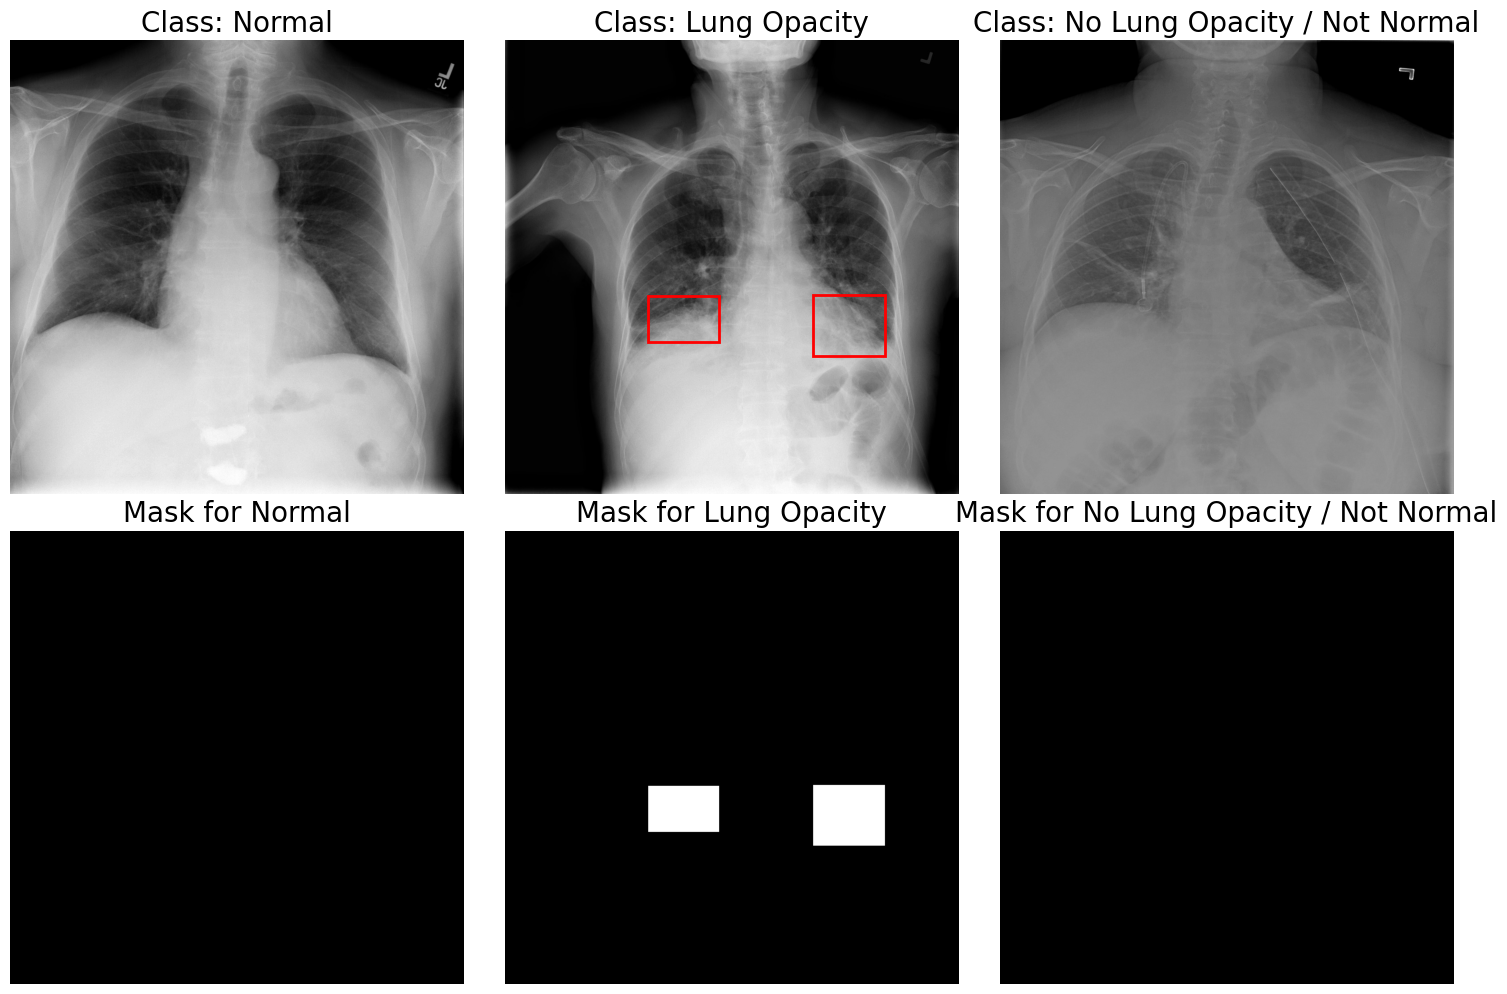

In [ ]:
df1 = pd.read_csv(main_dir + 'df_extended.csv')
show_images_with_boxes(df1, images_dir, mask_dir_png, 1)

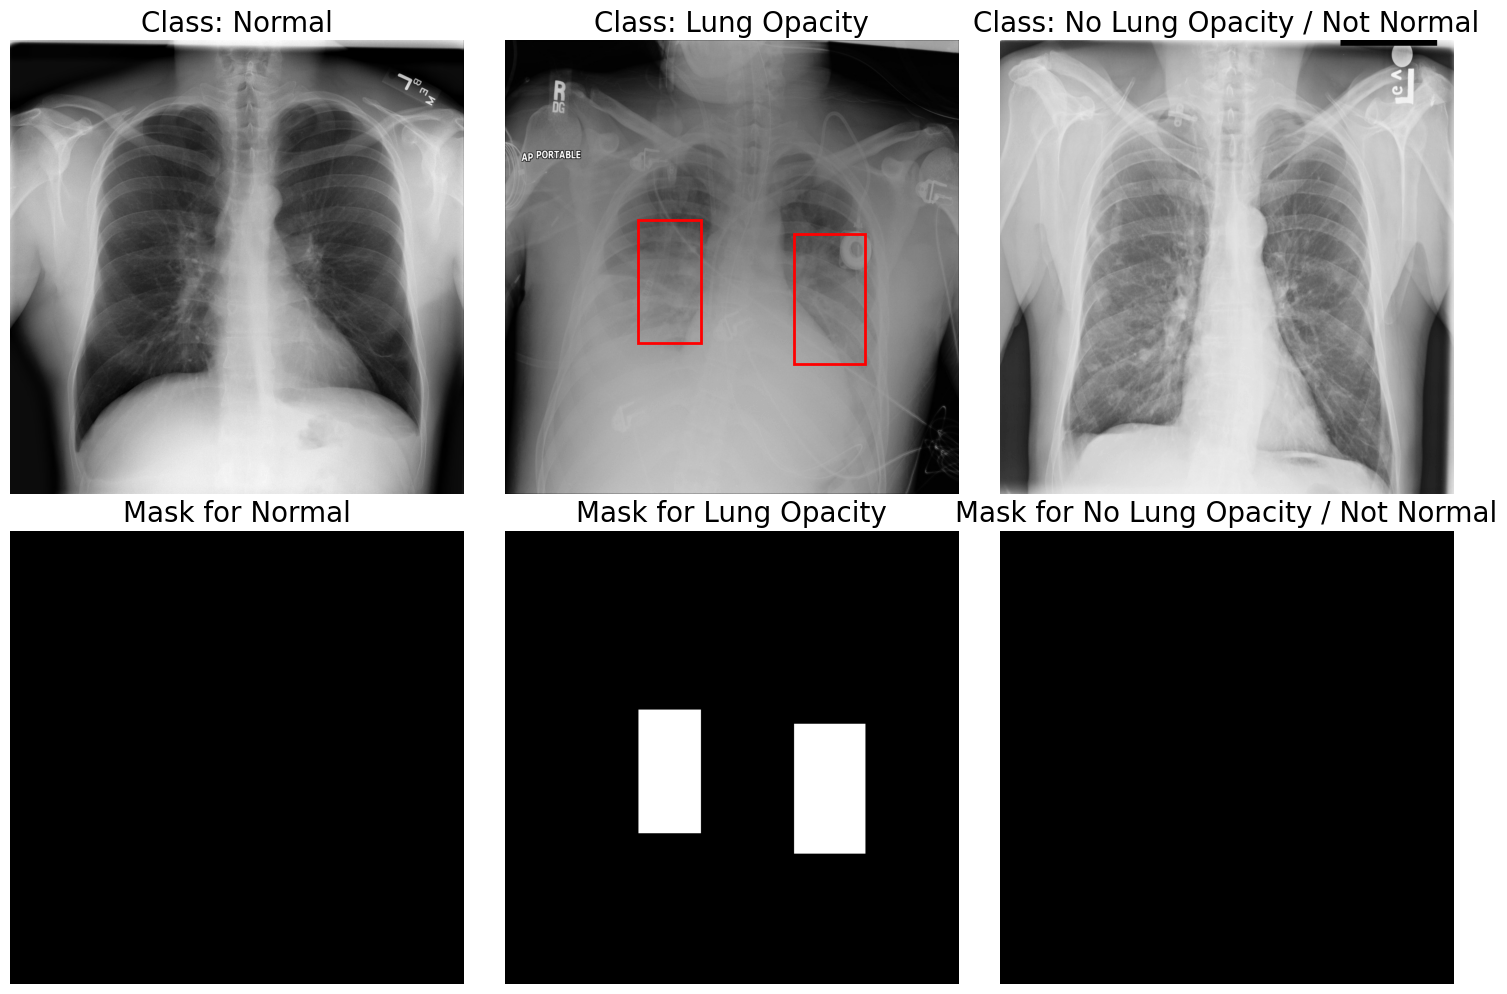

In [ ]:
df1 = pd.read_csv(main_dir + 'df_extended.csv')
show_images_with_boxes(df1, images_dir, mask_dir_png, 6)

In [ ]:
# Rutas de la imagen y la máscara
img_png_path = images_dir_png + '/' + 'c1f7889a-9ea9-4acb-b64c-b737c929599a.png'
mask_png_path = mask_dir_png + '/' + 'c1f7889a-9ea9-4acb-b64c-b737c929599a_mascara.png'

# Cargar la imagen PNG y la máscara PNG
image = cv2.imread(img_png_path)
mask = cv2.imread(mask_png_path)

# Comprobar las dimensiones de la imagen y la máscara
print("Dimensiones de imagen png", image.shape)
print("Dimensiones de mascara png", mask.shape)

Dimensiones de imagen png (1024, 1024, 3)
Dimensiones de mascara png (1024, 1024, 3)


## Normalizar la imagen

se realisa al incorporar el rocesamiento directamente en el flujo de datos de tu tf.data.Dataset. Esto permitirá realizar transformaciones adicionales en las imágenes, como normalización, aumento de datos (data augmentation), recortes, etc., de forma eficiente y en tiempo real durante el entrenamiento.

## Redimensionar imágenes:

se realisa al incorporar el rocesamiento directamente en el flujo de datos de tu tf.data.Dataset.

# 4.3.3.3. Balanceo de clases

In [ ]:
df_a_balancear = pd.read_csv(dataset_agrupado_dir)
df_a_balancear.shape
df_a_balancear.head()


,filename,filename_masc,Target,PatientAge,PatientSex,ViewPosition,lista_coordinadas
0,960c2843-0cc6-43ef-bf6e-c84d33b8f4e2.png,960c2843-0cc6-43ef-bf6e-c84d33b8f4e2_mascara.png,0,56.0,0,0,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."
1,7b3a085b-9c19-450b-8223-f6667774817d.png,7b3a085b-9c19-450b-8223-f6667774817d_mascara.png,0,42.0,1,0,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."
2,079f6a17-f9ce-48b2-a6dc-2a83eb07edf7.png,079f6a17-f9ce-48b2-a6dc-2a83eb07edf7_mascara.png,0,60.0,0,0,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."
3,d6406a7b-d4ce-4495-ac63-ccde4b062fa7.png,d6406a7b-d4ce-4495-ac63-ccde4b062fa7_mascara.png,1,23.0,1,0,"[{'x': 85.0, 'y': 101.0, 'width': 163.0, 'heig..."
4,6544c049-a898-4268-857f-7e6b9edaf878.png,6544c049-a898-4268-857f-7e6b9edaf878_mascara.png,0,47.0,0,1,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."


In [ ]:
class_counts = df_a_balancear['Target'].value_counts()
min_class = class_counts.min()


In [ ]:
class_counts=pd.DataFrame(class_counts)
class_counts["procentaje"]=class_counts.iloc[:,0]/class_counts.iloc[:,0].sum()
class_counts

,count,procentaje
Target,,
0,20568,0.774106
1,6002,0.225894


Eliminar filas aleatoriamente de la clase mayoritaria:

In [ ]:
df_balanced = pd.DataFrame()
for clas in class_counts.index:
    if class_counts[clas] > min_class:
        # Si la clase es mayoritaria, muéstrame aleatoriamente filas
        df_sample = df_a_balancear[df_a_balancear['Target'] == clas].sample(min_class, random_state=42)
        df_balanced = pd.concat([df_balanced, df_sample])
    else:
        # Si la clase es minoritaria, conservar todas las filas
        df_balanced = pd.concat([df_balanced, df_a_balancear[df_a_balancear['Target'] == clas]])
df_balanced['Target'].value_counts()

,count
Target,
0,6002
1,6002


Copiar imágenes y máscaras a nuevos directorios:

In [ ]:
for index, row in df_balanced.iterrows():
    img_src = os.path.join(images_dir_png, row['filename'])
    mask_src = os.path.join(mask_dir_png, row['filename_masc'])

    # Copiar imagen
    shutil.copy(img_src, os.path.join(images_dir_png_balanc, row['filename']))
    # Copiar máscara
    shutil.copy(mask_src, os.path.join(mask_dir_png_balanc, row['filename_masc']))

print("Dataset balanceado y archivos copiados.")

Dataset balanceado y archivos copiados.


In [ ]:
print("Cantidad de filas en la tabla: ", len(df_balanced["Target"]))
print(f"Cantidad de imágenes en el directorio de imágenes balanceadas: {len(os.listdir(images_dir_png_balanc))}")
print(f"Cantidad de máscaras en el directorio de máscaras balanceadas: {len(os.listdir(mask_dir_png_balanc))}")


Cantidad de filas en la tabla:  12004
Cantidad de imágenes en el directorio de imágenes balanceadas: 12004
Cantidad de máscaras en el directorio de máscaras balanceadas: 12004


In [ ]:
df_balanced.to_csv("df_balanced.csv")

# 4.3.3.4 División en conjunto de entrenamiento, validación y test

In [ ]:
df_a_dividir=pd.read_csv(main_dir + "df_balanced.csv")
#df_a_dividir=df_balanced.copy()

In [ ]:
df_train, df_test = train_test_split(df_a_dividir, test_size=0.05, random_state=42, stratify = df_a_dividir["Target"])
print("division existosa")
print("df_train",df_train.shape)
print("df_test", df_test.shape)
df_train.head()

division existosa
df_train (11403, 8)
df_test (601, 8)


,Unnamed: 0,filename,filename_masc,Target,PatientAge,PatientSex,ViewPosition,lista_coordinadas
1073,2050,32c00024-2c45-4ba5-a8e6-29bd9aaf85f4.png,32c00024-2c45-4ba5-a8e6-29bd9aaf85f4_mascara.png,0,65.0,1,1,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."
5515,15683,2f55650d-f85f-47e7-b6e6-79ad8e3c7c53.png,2f55650d-f85f-47e7-b6e6-79ad8e3c7c53_mascara.png,0,63.0,0,1,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."
8753,12368,73a0777c-caaf-405f-80ab-342715b384c9.png,73a0777c-caaf-405f-80ab-342715b384c9_mascara.png,1,22.0,1,0,"[{'x': 511.0, 'y': 269.0, 'width': 194.0, 'hei..."
5811,20554,89e2d8bc-2e4f-4f5f-8e92-06119fa63cfc.png,89e2d8bc-2e4f-4f5f-8e92-06119fa63cfc_mascara.png,0,33.0,1,1,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."
4092,10708,4b92f925-74f7-4941-94d7-0883aebab46a.png,4b92f925-74f7-4941-94d7-0883aebab46a_mascara.png,0,66.0,1,1,"[{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': ..."


In [ ]:
print("distribuicion por clases en train")
df_train["Target"].value_counts()/len(df_train["Target"])

distribuicion por clases en train


,count
Target,
1,0.500044
0,0.499956


In [ ]:
print("distribuicion por clases en test")
df_test["Target"].value_counts()/len(df_test["Target"])

distribuicion por clases en test


,count
Target,
0,0.500832
1,0.499168


In [ ]:
df_train.to_csv("df_train_balanced.csv",index=False)
df_test.to_csv("df_test_balanced.csv",index=False)
print("datos de entrenamiento y test se han guardado con exito")

datos de entrenamiento y test se han guardado con exito


# Preprocesamiento conjunto Kermany

se realisa dentro de ImageGenerator